In [1]:
import pandas as pd 
pd.options.mode.chained_assignment = None 
import numpy as np 
seed = 0 
np.random.seed(seed) 
import matplotlib.pyplot as plt 
import seaborn as sns 

import datetime as dt
import re 
import string
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from joblib import Parallel, delayed
import time 

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 

In [5]:
from google_play_scraper import app, reviews, Sort, reviews_all

scrapreview = reviews_all (
    'com.gojek.app',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=10000
)

In [6]:
import csv

with open('ulasan_gojek.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])

In [7]:
app_reviews_df = pd.DataFrame(scrapreview)
app_reviews_df.to_csv('ulasan_gojek.csv', index=False)
app_reviews_df.shape


(126000, 11)

In [8]:
clean_df = app_reviews_df.dropna()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30175 entries, 1 to 125991
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              30175 non-null  object        
 1   userName              30175 non-null  object        
 2   userImage             30175 non-null  object        
 3   content               30175 non-null  object        
 4   score                 30175 non-null  int64         
 5   thumbsUpCount         30175 non-null  int64         
 6   reviewCreatedVersion  30175 non-null  object        
 7   at                    30175 non-null  datetime64[ns]
 8   replyContent          30175 non-null  object        
 9   repliedAt             30175 non-null  datetime64[ns]
 10  appVersion            30175 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 2.8+ MB


In [9]:
clean_df = clean_df.drop_duplicates()
clean_df.shape

(30175, 11)

In [10]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text) 
    text = re.sub(r'RT[\s]', '', text) 
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text) 
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text

def casefoldingText(text): 
    text = text.lower()
    return text

def tokenizingText(text): 
    text = word_tokenize(text)
    return text

def filteringText(text): 
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return ' '.join(filtered)

def stemmingText(text): 
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    
    words = text.split()
    
    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text
    
def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [11]:
#Fixing Slang Words
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [12]:
#Before preprocessing
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
1,e6763d9e-275c-48b9-bcd3-87c0d1dd717c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya kecewa tadinya harga 26rb karna diskon 11...,3,7,4.91.1,2024-07-22 18:11:18,"Mohon maaf atas ketidaknyamanannya, Kak Iswan....",2024-07-22 20:33:54,4.91.1
2,c82ed572-fc1d-4918-a8ef-6e5b878c2e3c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sudah 2 kali pesan gocar susah jaringan terus ...,2,3,4.91.1,2024-07-21 14:26:56,"Hai Kak Siti, mohon maaf atas ketidaknyamanann...",2024-07-21 15:34:34,4.91.1
4,fcecd263-6061-4de6-b9f7-ecc2608922dc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi sudah sangat baik, tapi saya kecewa, ...",1,70,4.90.2,2024-07-11 11:37:32,"Hai Kak Boy, mohon maaf atas ketidaknyamananny...",2024-07-11 13:44:23,4.90.2
5,ad5d42d7-26b3-4b05-84d5-ec7a1630195c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Opsi pemilihan GOFOOD ""terdekat"" sekarang kura...",2,163,4.89.1,2024-06-26 03:44:12,"Hai Kak Christian, mohon maaf atas ketidaknyam...",2024-06-26 09:25:34,4.89.1
7,1bf37a40-af8c-4d1f-a677-07a46b121241,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Dear gojek..mengapa setelah pembaruan aplikasi...,1,84,4.90.2,2024-07-17 11:33:53,"Hai David Sinaga, mohon maaf ya. Laporan yang ...",2023-07-11 12:44:39,4.90.2
...,...,...,...,...,...,...,...,...,...,...,...
125983,ca55d08c-151b-4ba6-a75e-ccf5c2c4b0f4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sy ralat,,,, udah seharian sy mw mauk ke akun ...",1,0,4.7.4,2021-07-10 18:17:00,"Hai Aby Yasir, mohon maaf atas kendala yang ka...",2021-06-27 12:41:05,4.7.4
125984,4736a875-cbcd-4245-8291-442877ed1373,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Gojek skrang Ribet,klo laper shopeefood paling...",1,0,4.75.1,2023-10-06 00:36:08,"Hai Riky Tarnando, mohon maaf atas ketidaknyam...",2023-10-06 07:15:44,4.75.1
125986,2e0c7425-71eb-45e5-90b1-ab823b3f140c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kok skrang dapat driver bisa sampe 1jam sih ka...,1,1,4.68.1,2023-06-15 14:55:31,"Hai, mohon maaf atas kendalanya. Kesulitan unt...",2023-06-16 11:18:02,4.68.1
125989,3d966115-5932-4c90-8576-45a8c7fc8d98,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Gak bisa masuk ke aplikasi sama sekali,1,0,4.71.2,2023-08-09 22:41:31,"Hai Lia, mohon maaf atas kendalanya. Sebelum l...",2023-08-10 07:46:12,4.71.2


In [13]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

def process_batch (clean_df) :
    clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

    clean_df['text_stemming'] = Parallel(n_jobs=-1)(delayed(stemmingText)(text) for text in clean_df['text_stopword'])
  
    clean_df['text_akhir'] = clean_df['text_stemming'].apply(toSentence)
    
    return clean_df

def process_dataframe_in_batches(clean_df,batch_size) : 
    num_batches = len(clean_df) // batch_size + 1
    processed_batches = []
    
    for i in range (num_batches) :
        clean_df = clean_df.iloc[i*batch_size:(i+1)*batch_size].copy()
        processed_batch = process_batch(clean_df)
        processed_batches.append(processed_batch)
        
    return pd.concat(processed_batches, axis=0)

batch_size = 10000

start_time = time.time()
processed_df = process_dataframe_in_batches(clean_df,batch_size)
end_time = time.time()

print (f"Total processing time : {(end_time - start_time) / 60:.2f} minutes")

processed_df.to_csv('ulasan_gojek_processed.csv', index=False)   

Total processing time : 15.39 minutes


In [14]:
processed_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir
1,e6763d9e-275c-48b9-bcd3-87c0d1dd717c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya kecewa tadinya harga 26rb karna diskon 11...,3,7,4.91.1,2024-07-22 18:11:18,"Mohon maaf atas ketidaknyamanannya, Kak Iswan....",2024-07-22 20:33:54,4.91.1,Saya kecewa tadinya harga rb karna diskon rbpa...,saya kecewa tadinya harga rb karna diskon rbpa...,saya kecewa tadinya harga rb karena diskon rbp...,"[saya, kecewa, tadinya, harga, rb, karena, dis...",kecewa harga rb diskon rbpas cek menu menu lai...,kecewa harga rb diskon rbpas cek menu menu lai...,k e c e w a h a r g a r b d i s k o n ...
2,c82ed572-fc1d-4918-a8ef-6e5b878c2e3c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sudah 2 kali pesan gocar susah jaringan terus ...,2,3,4.91.1,2024-07-21 14:26:56,"Hai Kak Siti, mohon maaf atas ketidaknyamanann...",2024-07-21 15:34:34,4.91.1,Sudah kali pesan gocar susah jaringan terus p...,sudah kali pesan gocar susah jaringan terus p...,sudah kali pesan gocar susah jaringan terus pa...,"[sudah, kali, pesan, gocar, susah, jaringan, t...",kali pesan gocar susah jaringan internet full ...,kali pesan gocar susah jaring internet full kl...,k a l i p e s a n g o c a r s u s a h ...
4,fcecd263-6061-4de6-b9f7-ecc2608922dc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi sudah sangat baik, tapi saya kecewa, ...",1,70,4.90.2,2024-07-11 11:37:32,"Hai Kak Boy, mohon maaf atas ketidaknyamananny...",2024-07-11 13:44:23,4.90.2,Aplikasi sudah sangat baik tapi saya kecewa ha...,aplikasi sudah sangat baik tapi saya kecewa ha...,aplikasi sudah sangat baik tapi saya kecewa ha...,"[aplikasi, sudah, sangat, baik, tapi, saya, ke...",aplikasi kecewa gojek data riwayat transaksi p...,aplikasi kecewa gojek data riwayat transaksi g...,a p l i k a s i k e c e w a g o j e k d ...
5,ad5d42d7-26b3-4b05-84d5-ec7a1630195c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Opsi pemilihan GOFOOD ""terdekat"" sekarang kura...",2,163,4.89.1,2024-06-26 03:44:12,"Hai Kak Christian, mohon maaf atas ketidaknyam...",2024-06-26 09:25:34,4.89.1,Opsi pemilihan GOFOOD terdekat sekarang kurang...,opsi pemilihan gofood terdekat sekarang kurang...,opsi pemilihan gofood terdekat sekarang kurang...,"[opsi, pemilihan, gofood, terdekat, sekarang, ...",opsi pemilihan gofood terdekat efisien pemilih...,opsi pilih gofood dekat efisien pilih opsi dek...,o p s i p i l i h g o f o o d d e k a t ...
7,1bf37a40-af8c-4d1f-a677-07a46b121241,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Dear gojek..mengapa setelah pembaruan aplikasi...,1,84,4.90.2,2024-07-17 11:33:53,"Hai David Sinaga, mohon maaf ya. Laporan yang ...",2023-07-11 12:44:39,4.90.2,Dear gojekmengapa setelah pembaruan aplikasi p...,dear gojekmengapa setelah pembaruan aplikasi p...,dear gojekmengapa setelah pembaruan aplikasi p...,"[dear, gojekmengapa, setelah, pembaruan, aplik...",dear gojekmengapa pembaruan aplikasi posisi dr...,dear gojekmengapa baru aplikasi posisi driver ...,d e a r g o j e k m e n g a p a b a r u ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27636,f1fee407-f5be-4d27-ba8a-e09df742f393,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Parah pelayanan costumer service nya, pelayana...",1,4,4.36.1,2022-02-08 12:15:49,"Hai Aini Nur, terima kasih atas ulasan kamu. J...",2022-02-09 12:54:00,4.36.1,Parah pelayanan costumer service nya pelayanan...,parah pelayanan costumer service nya pelayanan...,parah pelayanan costumer service nya pelayanan...,"[parah, pelayanan, costumer, service, nya, pel...",parah pelayanan costumer service pelayanan gan...,parah layan costumer service layan ganti nomor...,p a r a h l a y a n c o s t u m e r s e ...
27639,18c7f294-76c3-4acb-8

In [106]:
import csv
import requests
from io import StringIO

def load_lexicon(url):
    lexicon = {}
    response = requests.get(url)
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        for row in reader:
            lexicon[row[0].strip()] = int(row[1])
    else:
        print(f"Failed to fetch lexicon data from {url}")
    return lexicon

lexicon_positive = load_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lexicon_negative = load_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

def sentiment_analysis_lexicon_indonesia(text):

    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
        
    for word in text:
        
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    
    polarity=''
    
    if (score > 0):
        polarity = 'positive'
    
    elif (score < 0):
        polarity = 'negative'
    
    return score, polarity


In [110]:
results = processed_df['text_tokenizingText'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
processed_df['polarity_score'] = results[0]
processed_df['polarity'] = results[1]
print(processed_df['polarity'].value_counts())

polarity
negative    8728
positive    1272
Name: count, dtype: int64


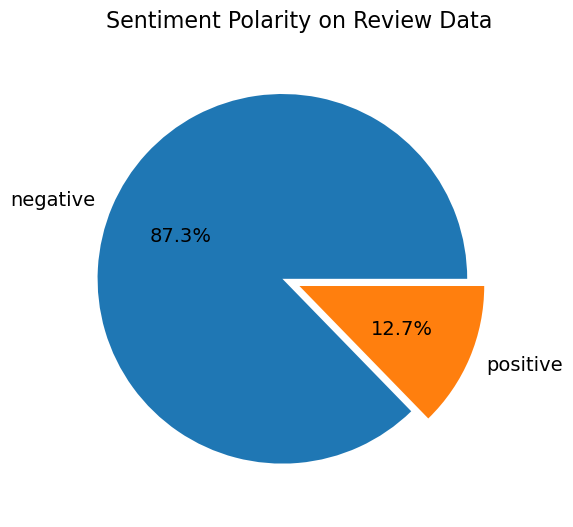

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))
sizes = [count for count in processed_df['polarity'].value_counts()]
labels = list(processed_df['polarity'].value_counts().index)
explode = (0.1, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

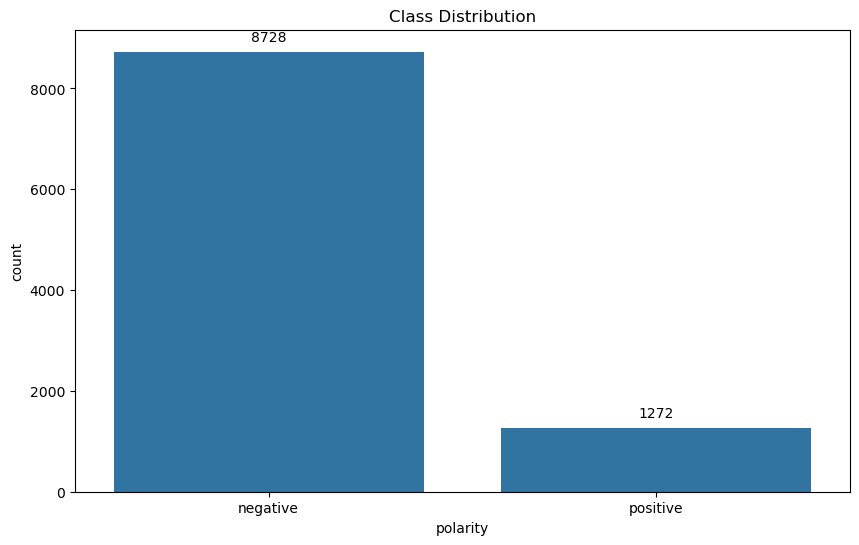

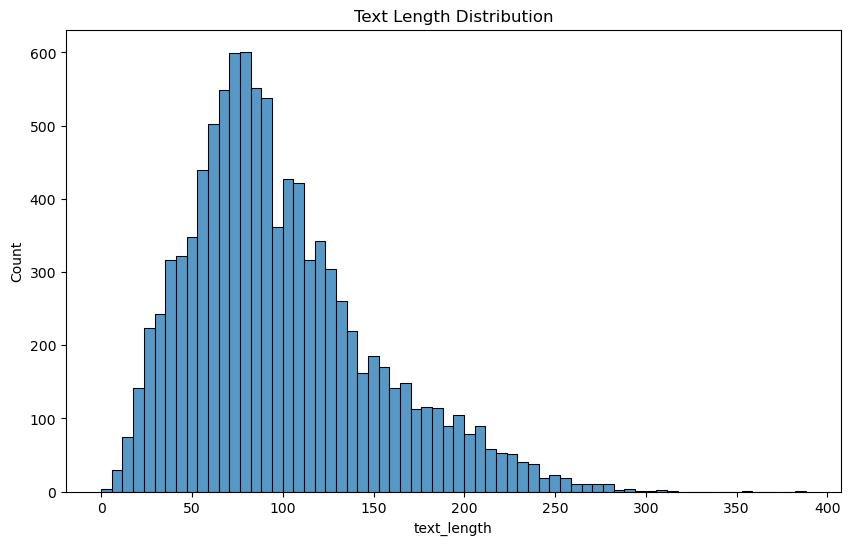

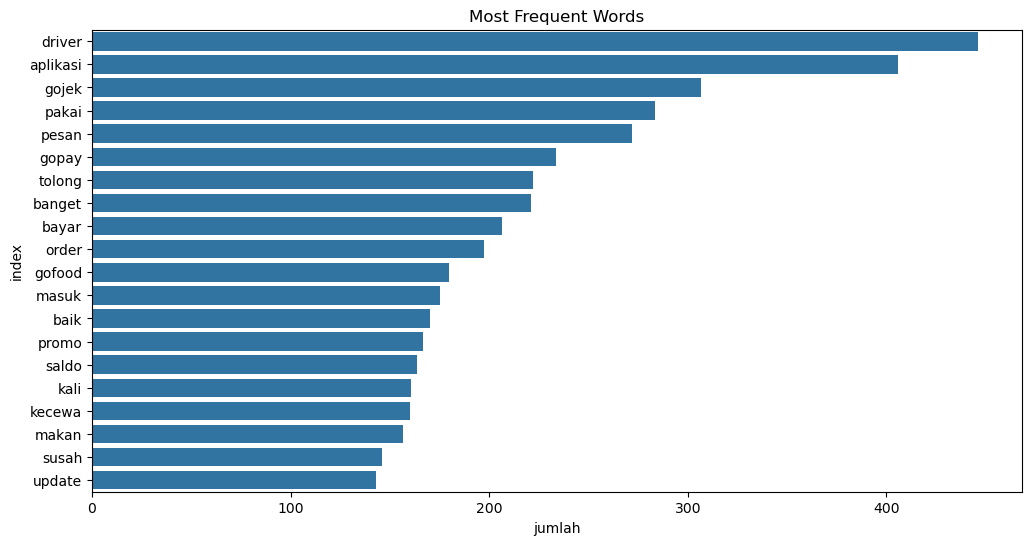

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x='polarity', data=processed_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

plt.figure(figsize=(10, 6))

processed_df['text_length'] = processed_df ['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(processed_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

plt.figure(figsize=(12, 6))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_df['text_stemming'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [116]:
import pandas as pd
import numpy as np 
import tensorflow as tf 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score


In [117]:
processed_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,...,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir,polarity_score,polarity,text_length
1,e6763d9e-275c-48b9-bcd3-87c0d1dd717c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya kecewa tadinya harga 26rb karna diskon 11...,3,7,4.91.1,2024-07-22 18:11:18,"Mohon maaf atas ketidaknyamanannya, Kak Iswan....",2024-07-22 20:33:54,...,Saya kecewa tadinya harga rb karna diskon rbpa...,saya kecewa tadinya harga rb karna diskon rbpa...,saya kecewa tadinya harga rb karena diskon rbp...,"[saya, kecewa, tadinya, harga, rb, karena, dis...",kecewa harga rb diskon rbpas cek menu menu lai...,kecewa harga rb diskon rbpas cek menu menu lai...,k e c e w a h a r g a r b d i s k o n ...,-74,negative,188
2,c82ed572-fc1d-4918-a8ef-6e5b878c2e3c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sudah 2 kali pesan gocar susah jaringan terus ...,2,3,4.91.1,2024-07-21 14:26:56,"Hai Kak Siti, mohon maaf atas ketidaknyamanann...",2024-07-21 15:34:34,...,Sudah kali pesan gocar susah jaringan terus p...,sudah kali pesan gocar susah jaringan terus p...,sudah kali pesan gocar susah jaringan terus pa...,"[sudah, kali, pesan, gocar, susah, jaringan, t...",kali pesan gocar susah jaringan internet full ...,kali pesan gocar susah jaring internet full kl...,k a l i p e s a n g o c a r s u s a h ...,-19,negative,167


In [157]:
x = processed_df['text_stemming']
y = processed_df['polarity']

In [133]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(x)

In [134]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

features_df

,aktif,akun,alamat,alas,aman,ambil,aneh,apa,apk,aplikasi,...,tunggu,tutup,uang,ubah,udh,ulang,uninstall,update,upgrade,voucher
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.101907,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.089470,...,0.0,0.210145,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.096742,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.104007,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.262911,0.0,0.0,0.203217,0.0,0.0,0.0,0.0,0.0
9996,0.290197,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9997,0.000000,0.357282,0.479336,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.000000,0.000000,0.323614,0.0,0.000000,0.334887,0.0,0.000000,0.328700,...,0.0,0.386019,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [166]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train.toarray(), y_train)

y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.8945
SVM - accuracy_test: 0.8815


In [170]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train.toarray(), y_train)

y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.99675
Random Forest - accuracy_test: 0.8795


In [193]:
new_sentence = input("Input new sentences : ")

new_sentence_cleaned = cleaningText(new_sentence)
new_sentence_casefolded = casefoldingText(new_sentence_cleaned)
new_sentence_slangfixed = fix_slangwords(new_sentence_casefolded)
new_sentence_tokenized = tokenizingText(new_sentence_slangfixed)
new_sentence_filtered = filteringText(new_sentence_tokenized)
new_sentence_final = toSentence(new_sentence_filtered)

X_new_sentence = tfidf.transform([new_sentence_final])

sentiment_analysis = random_forest.predict(X_new_sentence)

if sentiment_analysis[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Sentimen kalimat baru adalah NEGATIF.
